# Periodic grids

## p4: periodic spectral differentiation

In [1]:
using LinearAlgebra
N = 24

# Set up grid and differentiation matrix:
h = 2π / N
x = h * (1:N)
entry(k) = k==0 ? 0.0 : 0.5 * (-1)^k * cot(k * h / 2)
D = [ entry(mod(i-j,N)) for i in 1:N, j in 1:N ]

# Differentiation of a hat function:
v = @. max(0, 1 - abs(x - π) / 2)
w = D*v
hat = (;v, w)

# Differentiation of exp(sin(x)):
v = @. exp(sin(x))
vʹ = @. cos(x) * v
w = D*v
error = norm(w - vʹ, Inf)
smooth = (;v, w, error);

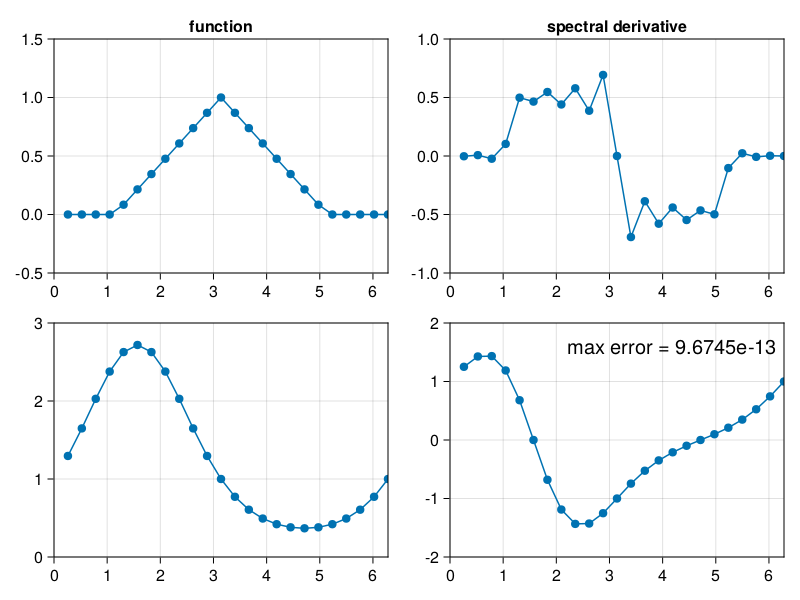

In [2]:
using CairoMakie, PyFormattedStrings

fig = Figure()
ax = Axis(fig[1, 1], title="function")
scatterlines!(x, hat.v)
limits!(ax, 0, 2π, -0.5, 1.5)
ax = Axis(fig[1, 2], title="spectral derivative")
scatterlines!(x, hat.w)
limits!(ax, 0, 2π, -1, 1)

ax = Axis(fig[2, 1])
scatterlines!(x, smooth.v)
limits!(ax, 0, 2π, 0, 3)
ax = Axis(fig[2, 2])
scatterlines!(x, smooth.w)
limits!(ax, 0, 2π, -2, 2)
text!(2.2, 1.4, text=f"max error = {smooth.error:.5g}", textsize=20)
fig

## p5: repetition of p4 via FFT

In [3]:
using FFTW 

# real case
function fderiv(v::Vector{T}) where T <: Real
    N = length(v)
    v̂ = rfft(v)
    ŵ = 1im * [0:N/2-1; 0] .* v̂
    return irfft(ŵ, N) 
end

# general case (2x slower)
function fderiv(v)
    N = length(v)
    v̂ = fft(v)
    ŵ = 1im * [0:N/2-1; 0; -N/2+1:-1] .* v̂
    return ifft(ŵ)
end

N = 24

# Set up grid and differentiation matrix:
h = 2π / N
x = h * (1:N)

# Differentiation of a hat function:
v = @. max(0, 1 - abs(x - π) / 2)
w = fderiv(v)
hat = (;v, w)

# Differentiation of exp(sin(x)):
v = @. exp(sin(x))
vʹ = @. cos(x) * v
w = fderiv(v)
error = norm(w - vʹ, Inf)
smooth = (;v, w, error);

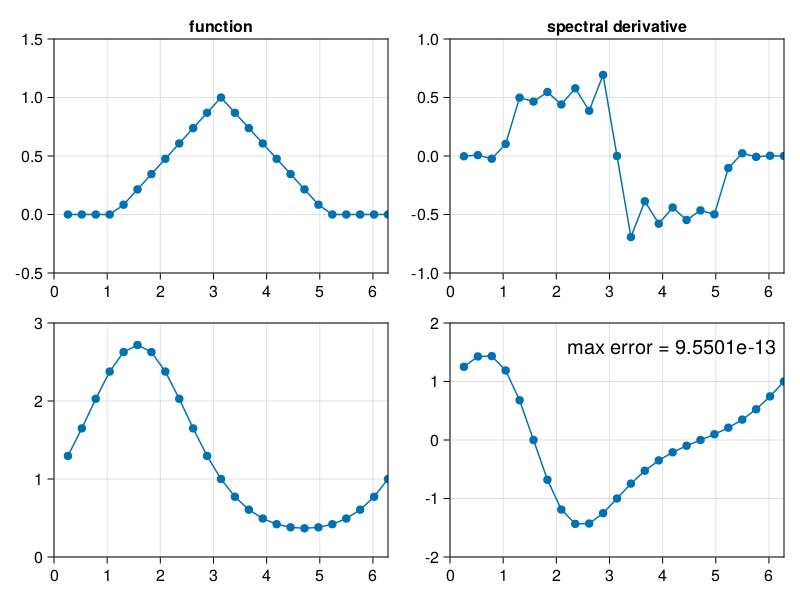

In [4]:
using CairoMakie, PyFormattedStrings

fig = Figure()
ax = Axis(fig[1, 1], title="function")
scatterlines!(x, hat.v)
limits!(ax, 0, 2π, -0.5, 1.5)
ax = Axis(fig[1, 2], title="spectral derivative")
scatterlines!(x, hat.w)
limits!(ax, 0, 2π, -1, 1)

ax = Axis(fig[2, 1])
scatterlines!(x, smooth.v)
limits!(ax, 0, 2π, 0, 3)
ax = Axis(fig[2, 2])
scatterlines!(x, smooth.w)
limits!(ax, 0, 2π, -2, 2)
text!(2.2, 1.4, text=f"max error = {smooth.error:.5g}", textsize=20)
fig

## p6: variable coefficient wave equation

In [5]:
using FFTW

function p6wave(⍺ = 1.57)
    # Grid, variable coefficient, and initial data:
    N = 128;  h = 2π / N
    x = h * (1:N)
    t = 0;  Δt = ⍺ / N
    c = @. 0.2 + sin(x - 1)^2
    v = @. exp(-100 * (x - 1) .^ 2)
    vold = @. exp(-100 * (x - 0.2Δt - 1) .^ 2)

    # Time-stepping by leap frog formula:
    tmax = 8
    nsteps = ceil(Int, tmax / Δt)
    Δt = tmax / nsteps
    V = [v fill(NaN, N, nsteps)]
    t = Δt*(0:nsteps)
    for i in 1:nsteps
        w = fderiv(V[:,i])
        V[:,i+1] = vold - 2Δt * c .* w
        vold = V[:,i]
        if norm(V[:,i+1], Inf) > 2.5
            nsteps = i
            break 
        end
    end
    return x,t[1:nsteps+1],V[:,1:nsteps+1]
end

x,t,V = p6wave(1.57);

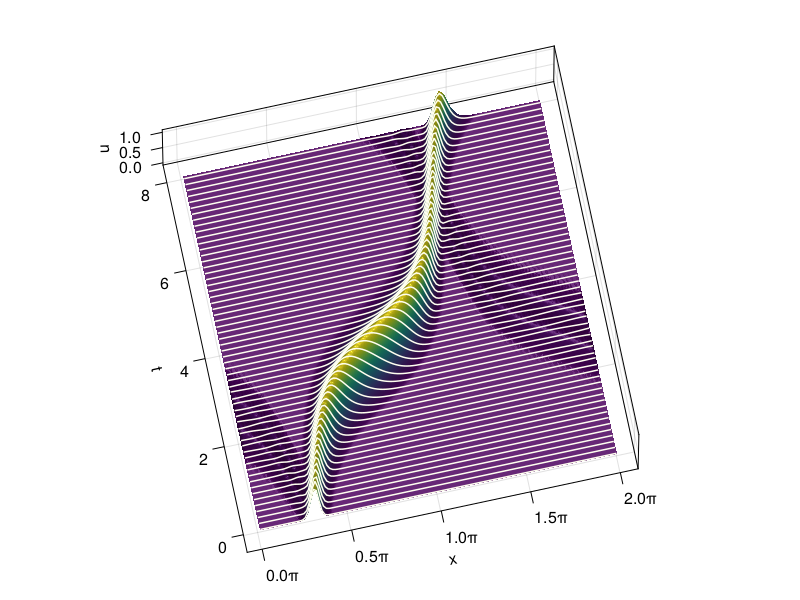

In [6]:
using CairoMakie, PyFormattedStrings

fig = Figure()
Axis3(fig[1, 1],
    xticks = MultiplesTicks(5, π, "π"),
    xlabel="x", ylabel="t", zlabel="u", 
    azimuth=4.5, elevation=1.44,
)
gap = max(1,round(Int, 0.15/(t[2]-t[1])) - 1)
surface!(x, t, V, colorrange=(0,1))
[ lines!(x, fill(t[j], length(x)), V[:, j].+.01, color=:ivory) for j in 1:gap:size(V,2) ]
fig

In [7]:
fig = Figure(size=(480,320))
index = Observable(1)
ax = Axis(fig[1, 1],
    xticks = MultiplesTicks(5, π, "π"),
    xlabel="x", ylabel="u"
)
lines!(x, @lift(V[:,$index]))
record(fig, "_build/html/p6wave.mp4", 1:4:size(V,2)+1) do i
    index[] = i
    ax.title = f"t = {t[i]:.2f}"
end;

<video autoplay controls><source src="p6wave.mp4" type="video/mp4"></video>

<!-- 
Unstable step size:

```{code-cell}
x,t,V = p6wave(1.9);
fig = Figure()
Axis3(fig[1, 1],
    xticks = MultiplesTicks(5, π, "π"),
    xlabel="x", ylabel="t", zlabel="u", 
    azimuth=4.5, elevation=1.44,
)
gap = max(1,round(Int, 0.15/(t[2]-t[1])) - 1)
surface!(x, t, V, colorrange=(0,1))
[ lines!(x, fill(t[j], length(x)), V[:, j].+.01, color=:ivory) for j in 1:gap:size(V,2) ]
fig
``` -->